### The goal of this project is to fit an ARIMA time series model to the daily stock prices of Facebook to predict the future value of stock prices.

### I hope to be able to identify trends in the data and model the underlying phenomenon that contribute to these trends.

In [88]:
import numpy as np
import os
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
import time
import datetime
from time import mktime
from datetime import datetime
from sklearn.metrics import mean_squared_error
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/helloaoi/anaconda3/envs/stats/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Data Preprocessing

Obtain Facebook's daily stock price for 2016 from Yahoo Finance

In [2]:
directories = [i for i in os.walk('../2016')]
directories = directories[0][1]
directories = directories[1:]

In [3]:
from datetime import timedelta, date

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2016, 1, 1)
end_dt = date(2016, 12, 31)
dates = [dt.strftime("%Y-%m-%d") for dt in daterange(start_dt, end_dt)]

In [4]:
df = pd.read_csv(directories[0]+"/prices.csv")
df = df[df.symbol == 'FB']

In [5]:
for i in directories[1:]:
    if os.path.isfile(i+'/prices.csv'):
        try:
            new = pd.read_csv(i+'/prices.csv')
            new = new[new.symbol == 'FB']
            df = pd.concat([df, new])
        except:
            continue

In [6]:
df = df.drop_duplicates().reset_index(drop = True)
df = df.drop(df.index[1]).reset_index(drop = True)

In [7]:
df = df[['date', 'close']].rename(columns = {'close':'price'})

In [8]:
df['datetime'] = [time.strptime(i, '%Y-%m-%d') for i in df.date]

In [9]:
df = pd.read_csv('data.csv')

In [10]:
df['datetime'] = [time.strptime(i, '%m-%d-%Y') for i in df.date]

In [11]:
directories = [i for i in os.walk('../2017')]
directories = directories[0][1]
directories = directories[1:]

In [15]:
df_2017 = pd.read_csv("../2017/"+directories[0]+"/prices.csv")
df_2017 = df_2017[df_2017.symbol == 'FB']

In [19]:
for i in directories[1:]:
    if os.path.isfile("../2017/"+i+'/prices.csv'):
        try:
            new = pd.read_csv("../2017/"+i+'/prices.csv')
            new = new[new.symbol == 'FB']
            df_2017 = pd.concat([df_2017, new])
        except:
            continue

In [21]:
df_2017 = df_2017.drop_duplicates().reset_index(drop = True)
df_2017 = df_2017.drop(df_2017.index[1]).reset_index(drop = True)

In [23]:
df_2017 = df_2017[['date', 'close']].rename(columns = {'close':'price'})

In [25]:
df_2017['datetime'] = [time.strptime(i, '%Y-%m-%d') for i in df_2017.date]

In [27]:
ts_2017 = df_2017.price

In [29]:
ts = df.price

In [30]:
ts.describe()

count    366.000000
mean     116.759240
std        8.998039
min       94.160004
25%      111.525000
50%      117.729999
75%      123.897501
max      133.279999
Name: price, dtype: float64

In [32]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title("{}".format(name))

def to_col_vector(arr):
    """Convert a one dimensional numpy array to a column vector."""
    return arr.reshape(-1, 1)

def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, including an intercept term."""
    return sm.add_constant(to_col_vector(arr), prepend=False)

def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, linear_trend)

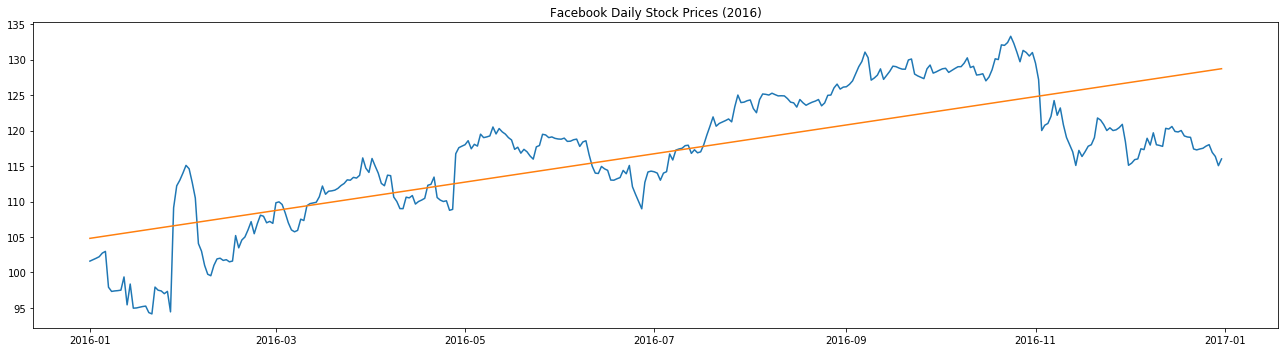

In [122]:
fig, ax = plt.subplots(1, figsize=(18, 5))
plot_linear_trend(ax, 'Facebook Daily Stock Prices (2016)', ts)
plt.tight_layout()

> Facebook stock prices show a increase in trend, but with irregular growth.

> Checked for common monthly seasonality trends like increase in stock at the end of months due to rapid buyers, but not found in this data.

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [35]:
def plot_acf_pacf(your_data, lags):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(your_data, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(your_data, lags=lags, ax=ax2)
    plt.show()

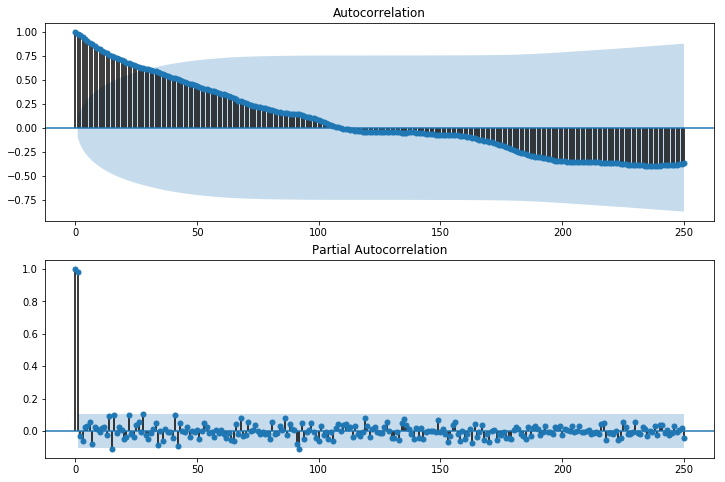

In [36]:
plot_acf_pacf(ts, 250)

> The series is not stationary because the series has positive autocorrelations for a high number of lags. The series requires differencing.

> Additionally, the PACF has a spike at lag 1 indicating that the series could benefit from an AR(1) model.

## Stationarity

In [37]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

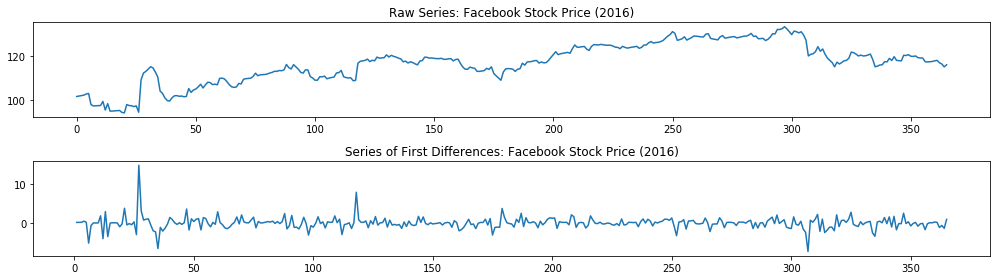

In [38]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, ts, 'Facebook Stock Price (2016)')
fig.tight_layout()

### Perform an Augmented Dickey-Fuller test on the differenced TS to ensure stationarity

In [39]:
test = sm.tsa.stattools.adfuller(ts)
print("ADF p-value for FB series: {0:2.2f}".format(test[1]))

ADF p-value for FB series: 0.26


In [40]:
test = sm.tsa.stattools.adfuller(ts.diff()[1:])
print("ADF p-value for differenced FB series: {0:2.2f}".format(test[1]))

ADF p-value for differenced FB series: 0.00


A series is **stationary** if the distribution of all equally spaced tuples taken from the series are identical. One consequence of this definition is that the correlation between two values of the series only depends on the lag between them - **autocorrelation**.

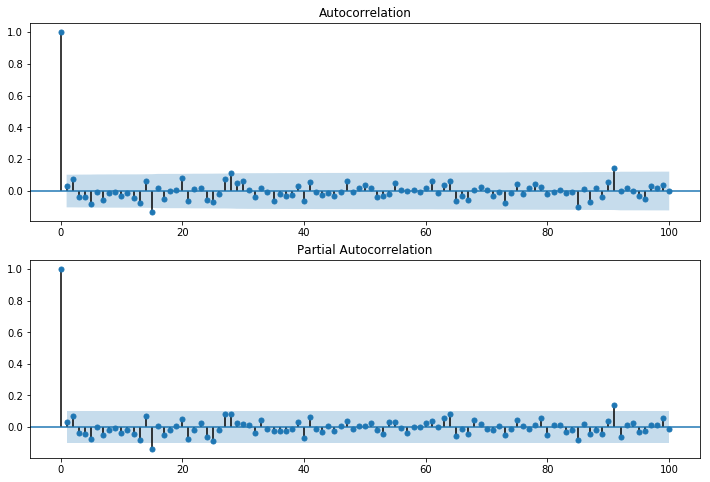

In [41]:
plot_acf_pacf(ts.diff()[1:], 100)

In [54]:
df['test'] = [datetime.datetime.fromtimestamp(mktime(i)) for i in df.datetime]
df_2017['test'] = [datetime.datetime.fromtimestamp(mktime(i)) for i in df_2017.datetime]

In [55]:
ts = pd.Series(df.price.values, index = df.test)
ts_2017 = pd.Series(df_2017.price.values, index = df_2017.test)

In [56]:
def format_list_of_floats(L):
    return ["{0:2.2f}".format(f) for f in L]

## Testing model parameters and choosing a model

In [87]:
parameters = [
    {'AR': 1, 'I': 1,'MA': 0},
    {'AR': 2, 'I': 1,'MA': 0},
    {'AR': 2, 'I': 0,'MA': 0},
    {'AR': 1, 'I': 0,'MA': 0},
    {'AR': 2, 'I': 2,'MA': 0},
    {'AR': 1, 'I': 2,'MA': 0}
]

models = {}
for params in parameters:
    models[(params['AR'], params['I'], params['MA'])] = ARIMA(ts, order=(params['AR'], params['I'], params['MA'])).fit()
    
for model_params in models:
    print("ARIMA({}, {}, {}) AIC: {}".format(model_params[0], model_params[1], model_params[2], models[model_params].aic))

ARIMA(1, 1, 0) AIC: 1345.8142595853994
ARIMA(2, 1, 0) AIC: 1345.888555628085
ARIMA(2, 0, 0) AIC: 1352.6928282965919
ARIMA(1, 0, 0) AIC: 1351.200309786203
ARIMA(2, 2, 0) AIC: 1444.1457228462882
ARIMA(1, 2, 0) AIC: 1468.9147989525516


In [83]:
ts_model = ARIMA(ts, order=(1, 1, 0)).fit()
print("ARIMA(1, 1, 0) coefficients from Facebook Stock Prices model:\n  Intercept {0:2.2f}\n  AR {1}".format(
    ts_model.params[0], 
        format_list_of_floats(list(ts_model.params[1:]))
    ))

ARIMA(1, 1, 0) coefficients from Facebook Stock Prices model:
  Intercept 114.48
  AR ['0.99']


> Here we test a combination of parameters and choose the model with the lowest AIC score - one with the best goodness of fit.

### Check for no autocorrelation in residuals

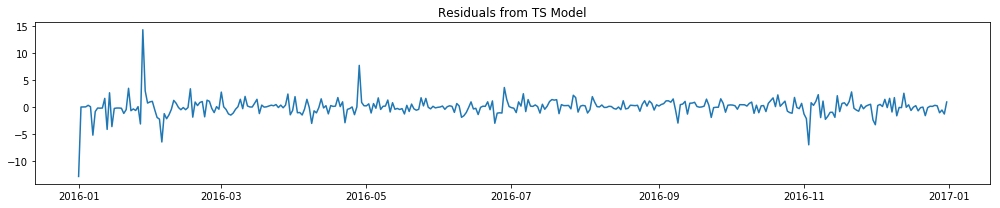

In [76]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(ts_model.resid.index, ts_model.resid)
ax.set_title("Residuals from TS Model")
plt.tight_layout()

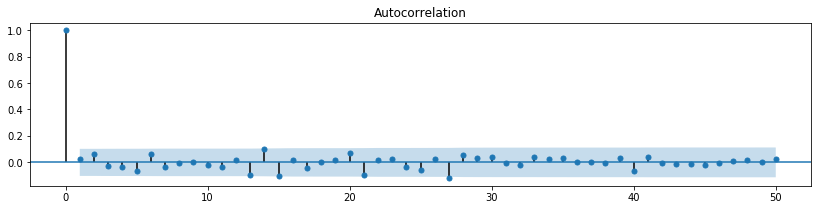

In [77]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(ts_model.resid, lags=50, ax=ax)

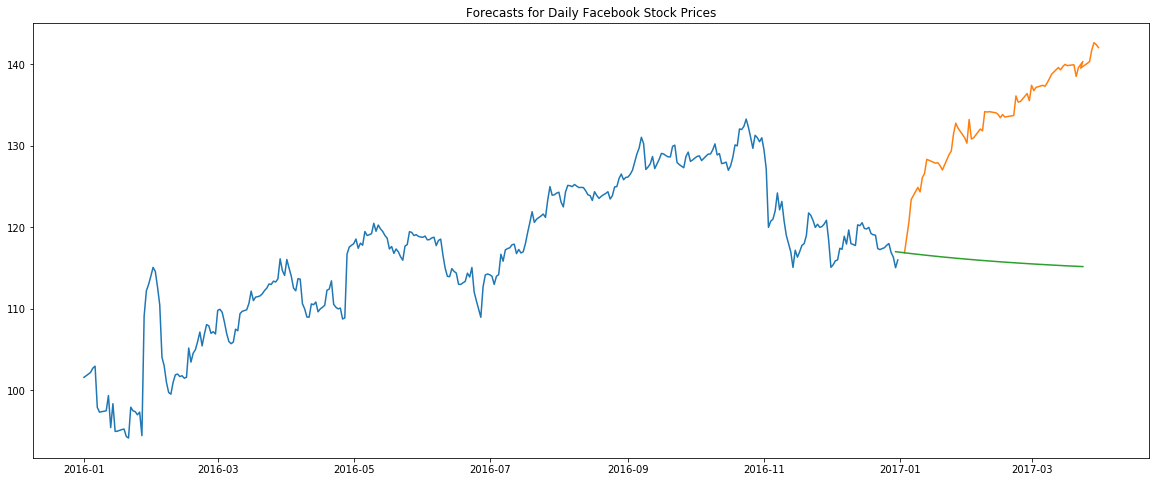

In [123]:
fig, ax = plt.subplots(1, figsize=(20, 8))
ax.plot(ts.index, ts)

preds = ts_model.predict('2016-12-30', '2017-03-030', 
                   dynamic=True)

ax.plot(ts_2017.index, ts_2017)

ax.plot(preds.index, preds)
ax.set_title("Forecasts for Daily Facebook Stock Prices")

## Weekly Time Series

In [62]:
df_week = df.iloc[::7, :]
ts_week = pd.Series(df_week.price.values, index = df_week.test)

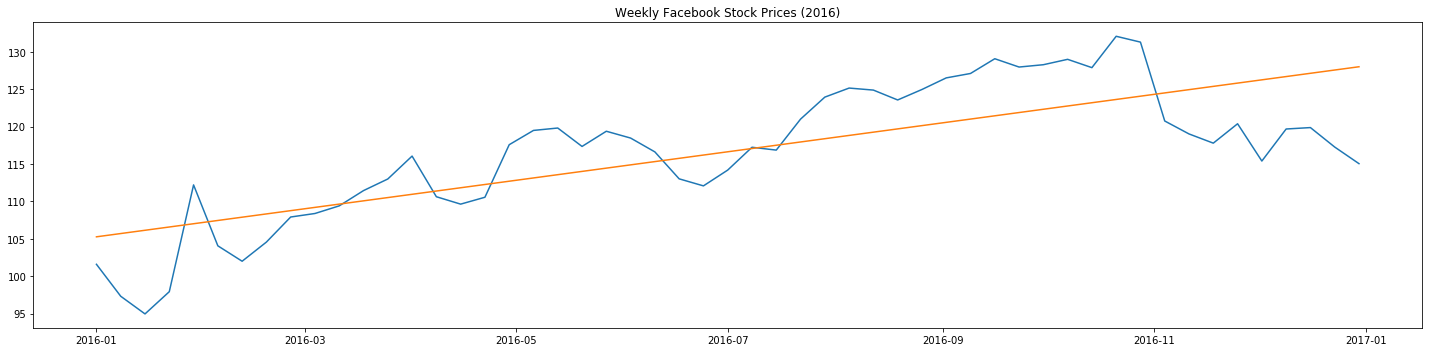

In [117]:
fig, ax = plt.subplots(1, figsize=(20, 5))
plot_linear_trend(ax, 'Weekly Facebook Stock Prices (2016)', ts_week)
plt.tight_layout()

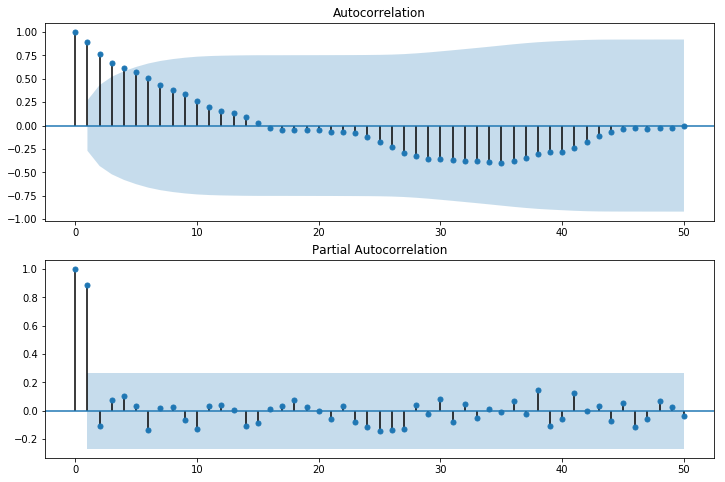

In [64]:
plot_acf_pacf(df_week.price, 50)

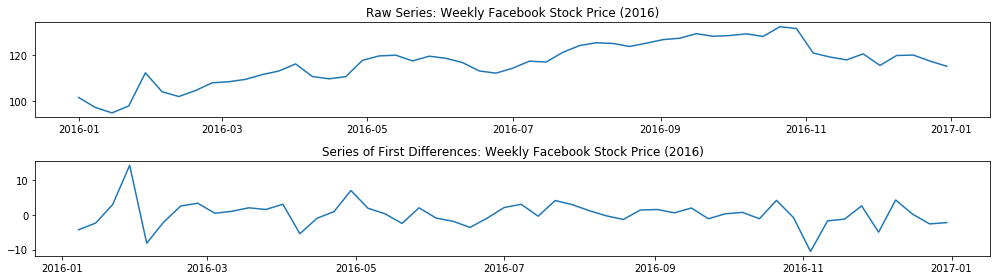

In [65]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, ts_week, 'Weekly Facebook Stock Price (2016)')
fig.tight_layout()

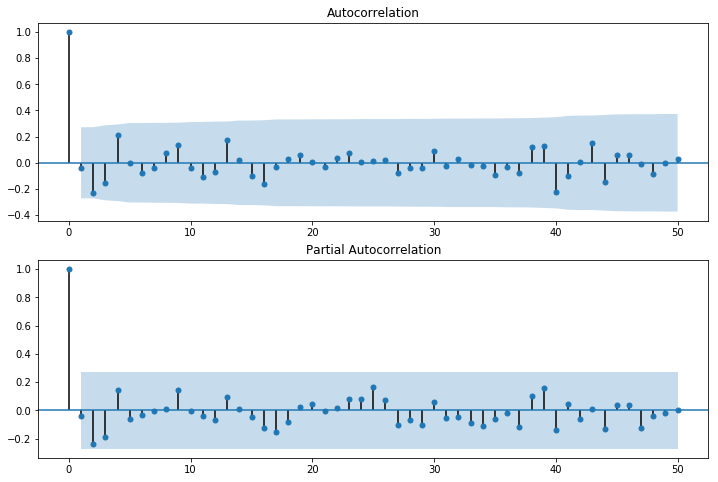

In [66]:
plot_acf_pacf(ts_week.diff()[1:], 50)

In [86]:
ts_model = ARIMA(ts_week, order=(1, 1, 0)).fit()
print("ARIMA(1, 1, 0) coefficients from Facebook Stock Prices model:\n  Intercept {0:2.2f}\n  AR {1}".format(
    ts_model.params[0], 
        format_list_of_floats(list(ts_model.params[1:]))
    ))

ARIMA(1, 1, 0) coefficients from Facebook Stock Prices model:
  Intercept 114.15
  AR ['0.92']


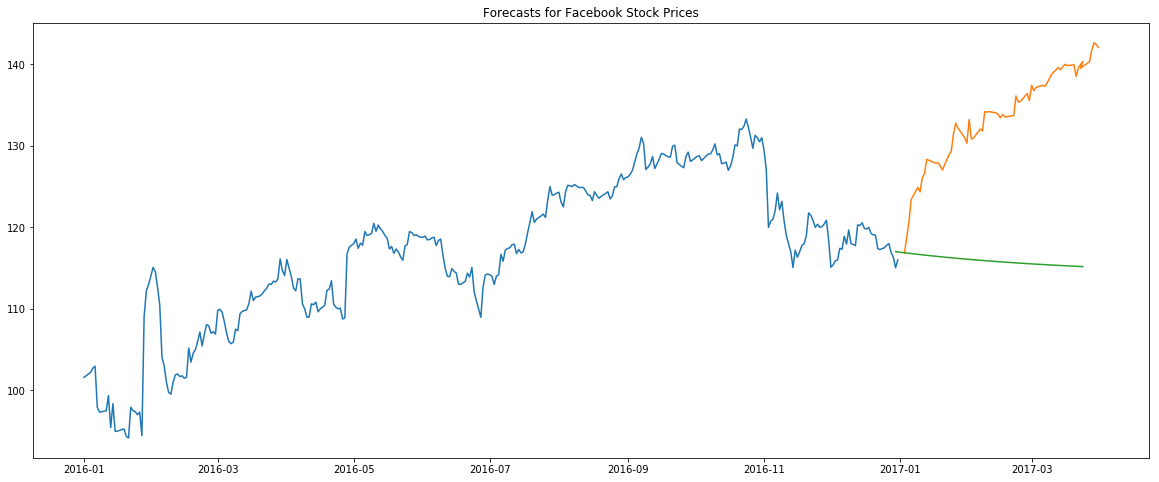

In [121]:
fig, ax = plt.subplots(1, figsize=(20, 8))
ax.plot(ts.index, ts)

preds = ts_model.predict('2016-12-30', '2017-03-30', 
                   dynamic=True)
ax.plot(ts_2017.index, ts_2017)
ax.plot(preds.index, preds)
ax.set_title("Forecasts for Facebook Stock Prices")

### Future Work

> Gather more data: 2015 daily stock prices

    > Investigate potential yearly seasonality of the time series and fit a SARIMAX model

> Try a random walk ARIMA to model random change in irregular TS (0, 1, 0)